# Projeto – Árvore de Decisão

Uma empresa de concessão de crédito para pequenas empresas possui um catálogo de seus clientes (PJ) **com informações como idade da empresa, faturamento mensal, nível de inovação, entre outras**. 

Para que esta empresa de concessão possa dar um atendimento mais apropriado para cada tipo de cliente, **eles classificam os clientes em segmentos**:  
**Starter, Bronze, Silver e Gold**.

Desta forma, para que seja possível classificar novos clientes, iremos construir um **classificador** que determina o segmento do cliente, com base nas informações disponíveis sobre o mesmo.


In [1]:
# EDA 
import pandas as pd
import pingouin as pg
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Otimização de Hiperparâmetros
import optuna

In [2]:
# Carregar Dataset
df_segmento = pd.read_csv('./datasets/dataset_segmento_clientes.csv')

In [3]:
# Visualizar os dados
df_segmento.head(10)

,atividade_economica,faturamento_mensal,numero_de_funcionarios,localizacao,idade,inovacao,segmento_de_cliente
0,Comércio,713109.95,12,Rio de Janeiro,6,1,Bronze
1,Comércio,790714.38,9,São Paulo,15,0,Bronze
2,Comércio,1197239.33,17,São Paulo,4,9,Silver
3,Indústria,449185.78,15,São Paulo,6,0,Starter
4,Agronegócio,1006373.16,15,São Paulo,15,8,Silver
5,Serviços,1629562.41,16,Rio de Janeiro,11,4,Silver
6,Serviços,771179.95,13,Vitória,0,1,Starter
7,Serviços,707837.61,16,São Paulo,10,6,Silver
8,Comércio,888983.66,17,Belo Horizonte,10,1,Bronze
9,Indústria,1098512.64,13,Rio de Janeiro,9,3,Bronze


In [4]:
# Estrutura do Dataset
df_segmento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   atividade_economica     500 non-null    object 
 1   faturamento_mensal      500 non-null    float64
 2   numero_de_funcionarios  500 non-null    int64  
 3   localizacao             500 non-null    object 
 4   idade                   500 non-null    int64  
 5   inovacao                500 non-null    int64  
 6   segmento_de_cliente     500 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 27.5+ KB


In [5]:
# Valores possíveis - Atividades Categóricas
df_segmento['atividade_economica'].unique()

array(['Comércio', 'Indústria', 'Agronegócio', 'Serviços'], dtype=object)

In [6]:
# Valores possíveis - Variáveis Categóricas
df_segmento['localizacao'].unique()

array(['Rio de Janeiro', 'São Paulo', 'Vitória', 'Belo Horizonte'],
      dtype=object)

In [7]:
# Valores possíveis - Variáveis Categóricas
df_segmento['segmento_de_cliente'].unique()

array(['Bronze', 'Silver', 'Starter', 'Gold'], dtype=object)

In [8]:
# Valores possíveis - Variáveis Categóricas
df_segmento['inovacao'].unique()

array([1, 0, 9, 8, 4, 6, 3, 7, 5, 2])

In [9]:
# Distribuição da Variável Segmento de Cliente (Target)

contagem_target = df_segmento.value_counts('segmento_de_cliente')
contagem_target

segmento_de_cliente
Silver     260
Bronze     202
Starter     22
Gold        16
Name: count, dtype: int64

In [10]:
# Criar uma lista ordenada do taget

lista_segmentos = ['Starter', 'Bronze', 'Silver', 'Gold']

In [11]:
# Distribuição da Variável Target - Contagem

px.bar(contagem_target, color=contagem_target.index, category_orders={'segmento_de_cliente': lista_segmentos})

In [12]:
# Distribuição de Variável Target - Percentual

percentual_target = contagem_target / len(df_segmento) * 100

px.bar(percentual_target, color=percentual_target.index, category_orders={'segmento_de_cliente': lista_segmentos})

In [13]:
# Distribuição de Variável Localização

percentual_localizacao = df_segmento.value_counts('localizacao') / len(df_segmento) * 100
px.bar(percentual_localizacao, color=percentual_localizacao.index)

In [14]:
# Distribuição de Variável Atividade Econômica

percentual_atividade = df_segmento.value_counts('atividade_economica') / len(df_segmento) * 100
px.bar(percentual_atividade, color=percentual_atividade.index)

In [15]:
# Distribuição de Variável Inovação

percentual_inovacao = df_segmento.value_counts('inovacao') / len(df_segmento) * 100
px.bar(percentual_inovacao, color=percentual_inovacao.index)

In [16]:
# Tabela de Contingência entre Localização e Target

crosstab_localizacao = pd.crosstab(df_segmento['localizacao'], df_segmento['segmento_de_cliente'], margins=True)[lista_segmentos].reset_index()
tabela_localizacao = ff.create_table(crosstab_localizacao)

# Mostrar a Crosstab
tabela_localizacao.show()

In [17]:
# Tabela de Contingência entre Atividade e Target

crosstab_atividade = pd.crosstab(df_segmento['atividade_economica'], df_segmento['segmento_de_cliente'], margins=True)[lista_segmentos].reset_index()
tabela_localizacao = ff.create_table(crosstab_atividade)

# Mostrar a Crosstab
tabela_localizacao.show()

In [18]:
# Tabela de Contingência entre Inovação e Target

crosstab_inovacao = pd.crosstab(df_segmento['inovacao'], df_segmento['segmento_de_cliente'], margins=True)[lista_segmentos].reset_index()
tabela_localizacao = ff.create_table(crosstab_inovacao)

# Mostrar a Crosstab
tabela_localizacao.show()

In [19]:
# Distribuição Idade da empresa

px.histogram(df_segmento, x='idade')

In [20]:
# Distribuição Faturamento mensal

px.histogram(df_segmento, x='faturamento_mensal')

In [21]:
# BoxPlot entre idade e Segmento
px.box(df_segmento, x='segmento_de_cliente', y='idade', color='segmento_de_cliente', category_orders={'segmento_de_cliente': lista_segmentos})

In [22]:
# BoxPlot entre Faturamento Mensal e Segmento
px.box(df_segmento, x='segmento_de_cliente', y='faturamento_mensal', color='segmento_de_cliente', category_orders={'segmento_de_cliente': lista_segmentos})

In [23]:
# Teste de Qui-Quadrado de Pearson
# H0 - as variáveis são independentes
# H1 - as variáveis não são independentes
# Se p-value > 0.05, aceita a hipótese nula, caso contrário rejeita
valor_esperado, valor_observado, estatisticas = pg.chi2_independence(df_segmento, 'segmento_de_cliente', 'inovacao')

c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\pingouin\contingency.py:151: UserWarning:

Low count on observed frequencies.

c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\pingouin\contingency.py:151: UserWarning:

Low count on expected frequencies.

c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\scipy\stats\_stats_py.py:7344: RuntimeWarning:

divide by zero encountered in power

c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\scipy\stats\_stats_py.py:7344: RuntimeWarning:

invalid value encountered in multiply

c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\scipy\stats\_stats_py.py:7341: RuntimeWarning:

divide by zero encountered in divide



In [24]:
# Valor Esperado
# É a frequência que seria esperada se não houvesse associação entre as variáveis
# É calculado utilizando a distribução assumida no teste qui-quadrado
valor_esperado

inovacao,0,1,2,3,4,5,6,7,8,9
segmento_de_cliente,,,,,,,,,,
Bronze,21.008,23.028,22.624,19.392,17.372,17.372,21.816,21.412,18.988,18.988
Gold,1.664,1.824,1.792,1.536,1.376,1.376,1.728,1.696,1.504,1.504
Silver,27.040,29.640,29.120,24.960,22.360,22.360,28.080,27.560,24.440,24.440
Starter,2.288,2.508,2.464,2.112,1.892,1.892,2.376,2.332,2.068,2.068


In [25]:
# Valor Observado
# É a frequência real dos dados coletados
valor_observado

inovacao,0,1,2,3,4,5,6,7,8,9
segmento_de_cliente,,,,,,,,,,
Bronze,36,44,32,22,12,14,15,12,9,6
Gold,0,0,0,0,0,3,0,5,4,4
Silver,10,5,20,25,30,25,38,36,34,37
Starter,6,8,4,1,1,1,1,0,0,0


In [26]:
# Estatísticas
estatisticas.round(5)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00000,164.29399,27.0,0.0,0.33095,0.99850
1,cressie-read,0.66667,165.49946,27.0,0.0,0.33216,0.99861
2,log-likelihood,0.00000,181.48878,27.0,0.0,0.34784,0.99951
3,freeman-tukey,-0.50000,NaN,27.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.00000,inf,27.0,0.0,inf,NaN
5,neyman,-2.00000,NaN,27.0,NaN,NaN,NaN


- As variáveis localizacao e segmento de cliente são independentes. Qui-Quadrado (p-value = 0.81714)
- As variáveis atividade economica e segmento de cliente são independentes. Qui-Quadrado (p-value = 0.35292)
- As variáveis inovção e segmento de cliente não são independentes. Qui-Quadrado (p-value = 0.0)

### Treinamento do Modelo


In [27]:
# Separar X e y
X = df_segmento.drop(columns=['segmento_de_cliente'])
y = df_segmento['segmento_de_cliente']

In [28]:
# Pipeline
# OneHotEncode nas variáveis categóricas
# Treinamento do Modelo

# Lista de variáveis categóricas
categorical_features = ['atividade_economica', 'localizacao']

# Criar um transformador de variáveis categóricas usando OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Pipeline com Pre-processor e o modelo de arvore de decisão
dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier())])

### Validação Cruzada

In [29]:
# Treinar o modelo com validação cruzada, usando StatifiedKFold, dado que as classes estão desbalanceadas

cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=51)
metrics_result = cross_validate(dt_model, X, y, cv=cv_folds, scoring=['accuracy'], return_estimator=True)

In [30]:
# Mostrar Retorno do Cross Validator
metrics_result

{'fit_time': array([0.00952196, 0.00527978, 0.004884  ]),
 'score_time': array([0.00548291, 0.00369358, 0.00365639]),
 'estimator': [Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='most_frequent')),
                                                                    ('onehot',
                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                    ['atividade_economica',
                                                     'localizacao'])])),
                  ('classifier', DecisionTreeClassifier())]),
  Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
        

In [31]:
# Média da Acurácia considerando os 3 splits
metrics_result['test_accuracy'].mean()

np.float64(0.4739917754851743)

In [32]:
# Acurácia
# Total de previsões corretas / total de previsões

### Métricas

In [33]:
#  Fazendo predições usando Cross Validation
y_pred = cross_val_predict(dt_model, X, y, cv=cv_folds)

In [34]:
# Avalia o desempenho do modelo
classification_report_str = classification_report(y, y_pred)
print(f'Relatório de Classificação: \n{classification_report_str}')

Relatório de Classificação: 
              precision    recall  f1-score   support

      Bronze       0.41      0.36      0.38       202
        Gold       0.00      0.00      0.00        16
      Silver       0.51      0.63      0.57       260
     Starter       0.00      0.00      0.00        22

    accuracy                           0.47       500
   macro avg       0.23      0.25      0.24       500
weighted avg       0.43      0.47      0.45       500



c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



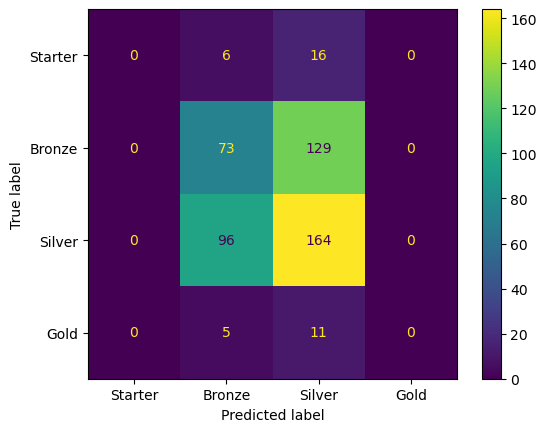

In [35]:
# Mostrar Matriz de Confusão
confusion_matrix_modelo = confusion_matrix(y, y_pred, labels=lista_segmentos)
disp = ConfusionMatrixDisplay(confusion_matrix_modelo, display_labels=lista_segmentos)
disp.plot()

### Tuning de Hiperparâmetros

In [36]:
# Ajustar hiperparâmetros do Modelo usando Optuna
# min_samples_leaf = Mínimo de instâncias requerido para formar uma folha (nó terminal)
# max_depth = Profundidade máxima da árvore

def decisiontree_optuna(trial):

    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_depth = trial.suggest_int('max_depth', 2, 8)

    dt_model.set_params(classifier__min_samples_leaf=min_samples_leaf)
    dt_model.set_params(classifier__max_depth=max_depth)

    scores = cross_val_score(dt_model, X, y, cv=cv_folds, scoring='accuracy')

    return scores.mean()

In [37]:
# Executar a automação de experimentos
estudo_decisiontree = optuna.create_study(direction='maximize')
estudo_decisiontree.optimize(decisiontree_optuna, n_trials=200)

[I 2025-04-14 15:32:46,778] A new study created in memory with name: no-name-d4e2bcb1-c68e-43bb-abb6-5851049d2c63
[I 2025-04-14 15:32:46,828] Trial 0 finished with value: 0.4519755669384123 and parameters: {'min_samples_leaf': 19, 'max_depth': 4}. Best is trial 0 with value: 0.4519755669384123.
[I 2025-04-14 15:32:46,861] Trial 1 finished with value: 0.4699877353726283 and parameters: {'min_samples_leaf': 15, 'max_depth': 3}. Best is trial 1 with value: 0.4699877353726283.
[I 2025-04-14 15:32:46,890] Trial 2 finished with value: 0.4739917754851743 and parameters: {'min_samples_leaf': 6, 'max_depth': 7}. Best is trial 2 with value: 0.4739917754851743.
[I 2025-04-14 15:32:46,922] Trial 3 finished with value: 0.4699877353726283 and parameters: {'min_samples_leaf': 4, 'max_depth': 3}. Best is trial 2 with value: 0.4739917754851743.
[I 2025-04-14 15:32:46,953] Trial 4 finished with value: 0.4679797032441142 and parameters: {'min_samples_leaf': 20, 'max_depth': 6}. Best is trial 2 with value

In [38]:
print(f'Melhor acurácia: {estudo_decisiontree.best_value}')
print(f'Melhores parâmetros: {estudo_decisiontree.best_params}')

Melhor acurácia: 0.4740518962075848
Melhores parâmetros: {'min_samples_leaf': 16, 'max_depth': 2}


### Visualizar Árvore


In [39]:
# Preparar o Conjunto de Dados para treinar e conseguir visualizar a árvore
X_train_tree = X.copy()
X_train_tree['localizacao_label'] = X_train_tree.localizacao.astype('category').cat.codes
X_train_tree['atividade_economica_label'] = X_train_tree.atividade_economica.astype('category').cat.codes
X_train_tree.drop(columns=['localizacao', 'atividade_economica'], axis=1, inplace=True)
X_train_tree.rename(columns={'localizacao_label': 'localizacao', 'atividade_economica_label': 'atividade_economica'}, inplace=True)
X_train_tree.head(10)

,faturamento_mensal,numero_de_funcionarios,idade,inovacao,localizacao,atividade_economica
0,713109.95,12,6,1,1,1
1,790714.38,9,15,0,2,1
2,1197239.33,17,4,9,2,1
3,449185.78,15,6,0,2,2
4,1006373.16,15,15,8,2,0
5,1629562.41,16,11,4,1,3
6,771179.95,13,0,1,3,3
7,707837.61,16,10,6,2,3
8,888983.66,17,10,1,0,1
9,1098512.64,13,9,3,1,2


In [40]:
# Treinar o modelo com o conjunto de hiperparâmetros ideal

clf_decisiontree = DecisionTreeClassifier(min_samples_leaf=estudo_decisiontree.best_params['min_samples_leaf'],
                                          max_depth=estudo_decisiontree.best_params['max_depth'])

y_train_tree = y.copy()

clf_decisiontree.fit(X_train_tree, y_train_tree)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=16)

[Text(0.5, 0.8333333333333334, 'inovacao <= 2.5\ngini = 0.563\nsamples = 500\nvalue = [202, 16, 260, 22]\nclass = Silver'),
 Text(0.25, 0.5, 'faturamento_mensal <= 462109.0\ngini = 0.482\nsamples = 165\nvalue = [112, 0, 35, 18]\nclass = Starter'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.375\nsamples = 16\nvalue = [4, 0, 0, 12]\nclass = Gold'),
 Text(0.375, 0.16666666666666666, 'gini = 0.418\nsamples = 149\nvalue = [108, 0, 35, 6]\nclass = Starter'),
 Text(0.75, 0.5, 'faturamento_mensal <= 549601.438\ngini = 0.474\nsamples = 335\nvalue = [90.0, 16.0, 225.0, 4.0]\nclass = Silver'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.459\nsamples = 37\nvalue = [26, 0, 7, 4]\nclass = Starter'),
 Text(0.875, 0.16666666666666666, 'gini = 0.416\nsamples = 298\nvalue = [64.0, 16.0, 218.0, 0.0]\nclass = Silver')]

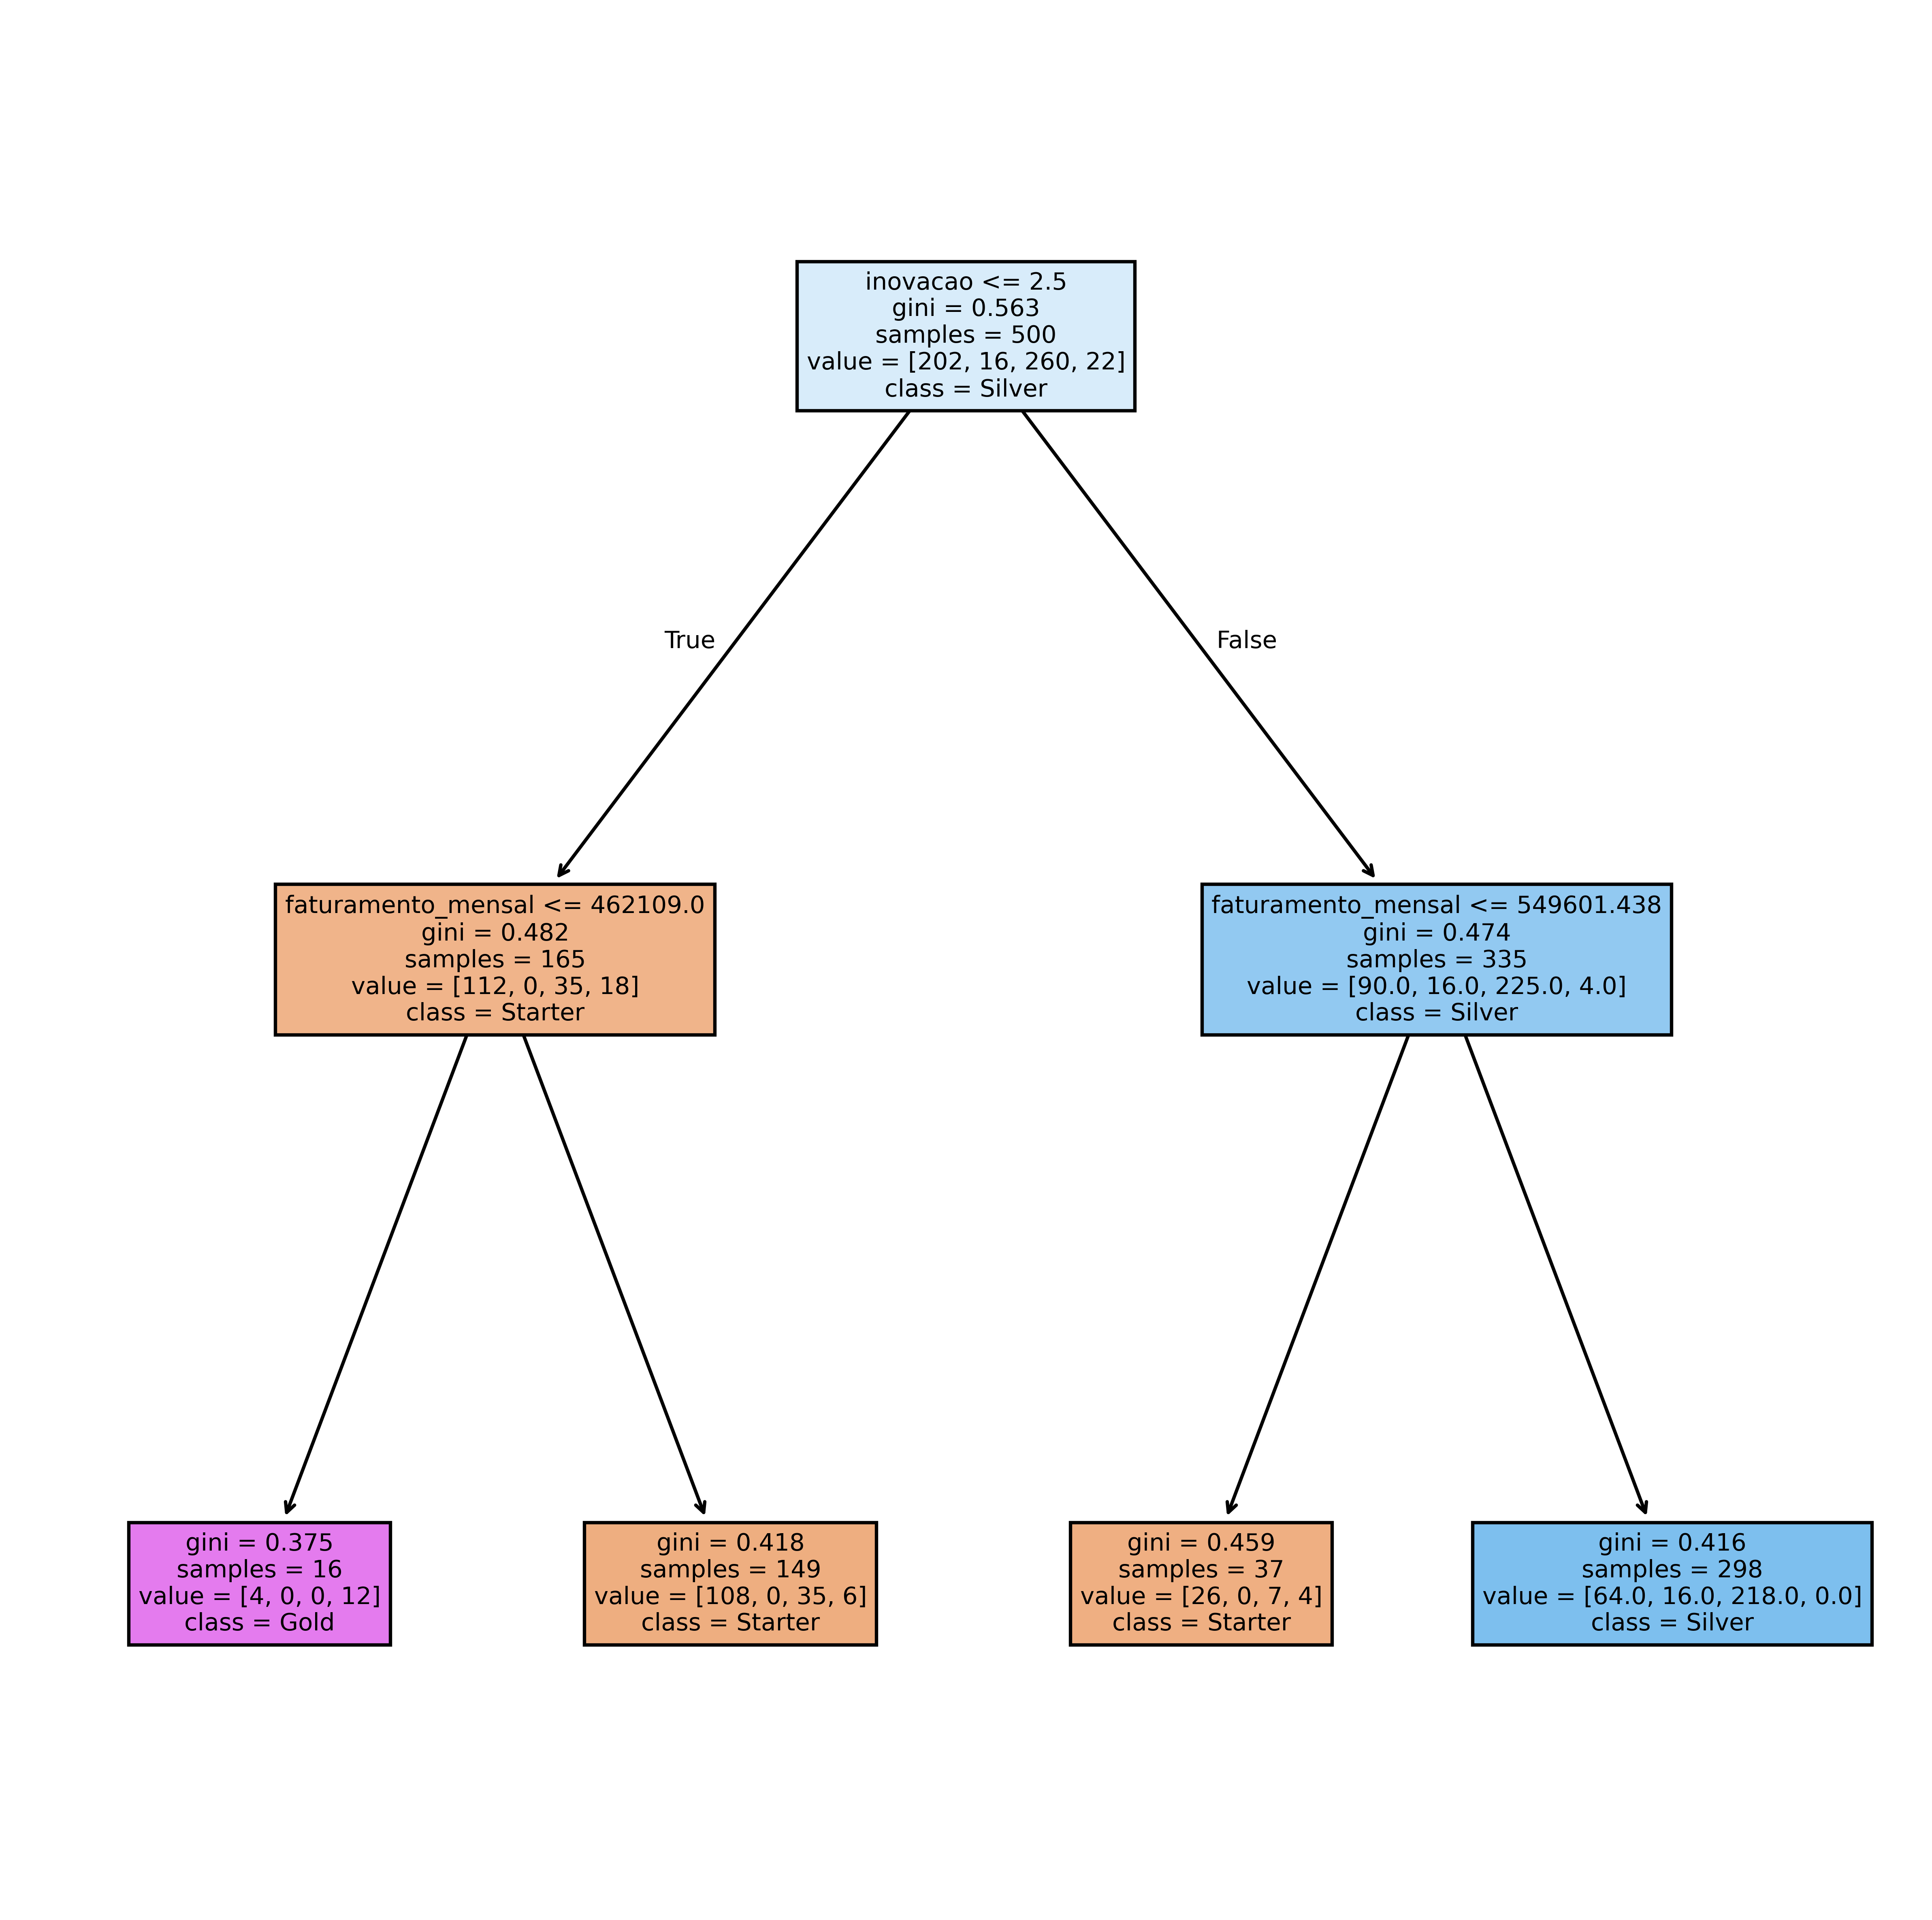

In [41]:
# Visualizar Árvore de Decisão com Plot Tree
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(10,10), dpi=600)

plot_tree(clf_decisiontree,
          feature_names=X_train_tree.columns.to_numpy(),
          class_names=lista_segmentos,
          filled = True)

### Salvar Modelo

In [42]:
import joblib

# Criar um pipeline "tunado"
dt_model_tunado = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', 
                                   DecisionTreeClassifier(
                                        min_samples_leaf=estudo_decisiontree.best_params['min_samples_leaf'],
                                        max_depth=estudo_decisiontree.best_params['max_depth']))])

# Treinar Modelo Tunado
dt_model_tunado.fit(X, y)

# Salvar Modelo
joblib.dump(dt_model_tunado, 'modelo_classificacao_decision_tree.pkl')

['modelo_classificacao_decision_tree.pkl']

### Entregar modelo como App de Predição Batch (por arquivo)

In [43]:
import gradio as gr 

modelo = joblib.load('./modelo_classificacao_decision_tree.pkl')

def predict(arquivo):
    df_empresas = pd.read_csv(arquivo.name)
    y_pred = modelo.predict(df_empresas)
    df_segmentos = pd.DataFrame(y_pred, columns=['segmento_de_cliente'])
    df_predicoes = pd.concat([df_empresas, df_segmentos], axis=1)
    df_predicoes.to_csv('./predicoes.csv', index=False)
    return './predicoes.csv'

demo = gr.Interface(
    predict,
    gr.File(file_types=[".csv"]),
    "file"
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
